# Milestone 2: EDA
## Module E: Predicting COVID-19 Cases
- Austin Rochon
- Emily Xie
- Mark Lock

<hr style="height:2pt">

## Table of Contents

0. [Introduction](#introduction)
1. [Global COVID-19 Data](#global)
2. [U.S. COVID-19 Data](#us)
3. [Analyzing Predictors](#predictors)  
    a. [Google Community Mobility Reports](#google_community_reports)  
    b. [Google Search Data](#google_search_data)  

<a id='introduction'></a>
## Introduction
For our project (Module E), we are focusing on the COVID-19 pandemic. In particular, we will eventually want to predict future COVID-19 cases, given current predictor data. Thus, we are seeking to answer the question: **can we accurately project future COVID-19 cases, given predictor data?** In this milestone, will will be focusing on the EDA of both our predictor and response data. Our reponse data here will be the count of confirmed cases, and our potential predictors will be defined in the sections below. Therefore, much of the scope of the work in our EDA will be to answer the question: **which data points are predictive of future COVID-19 cases?**.  Now that we have outlined the scope of our EDA work, we can immediately answer the first question in the milestone assignment:


**Given everything you have learned, if you faced this data set in the wild, how would you proceed?** 
    
Because we are examining COVID-19 data, which is being reported in real time, we don't have to answer this question hypothetically. We are facing this data set "in the wild". We've approached the COVID-19 data by 1) exploring and summarizing the response data (cases) by examining it by several different groupings (country, state, etc). Next, we examined a few potential predictors to see which had the most power in projecting future cases. 

<a id='global'></a>
## Global COVID-19 Data
We'll start by examining the global COVID-19 data provided by [Johns Hopkins University](https://github.com/CSSEGISandData).

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# fetch global data from the Johns Hopkins github
covid_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [3]:
# clean global data. first, transpose all date columns such that we have a single date column
# with each date entry as a row
dates = []
non_dates = ["Province/State", "Country/Region", "Lat", "Long"]
for col in covid_global.columns:
    if col not in non_dates:
        dates.append(col)
        
    
covid_global = pd.melt(covid_global, id_vars=non_dates, value_vars=dates,
                var_name="date", value_name="confirmed")

# next, simplify the column names to make analysis later easier
covid_global.rename(columns={"Province/State": "province", 
                             "Country/Region": "country",
                             "Lat": "lat",
                             "Long": "long"}, inplace=True)
covid_global.head()

,province,country,lat,long,date,confirmed
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


In [6]:
# store most recent figures to a dataframe
max_date = covid_global["date"].max()
covid_global_mostrecent = covid_global.loc[covid_global["date"] == max_date]

In [7]:
covid_global_mostrecent

,province,country,lat,long,date,confirmed
19988,NaN,Afghanistan,33.00000,65.000000,4/7/20,423
19989,NaN,Albania,41.15330,20.168300,4/7/20,383
19990,NaN,Algeria,28.03390,1.659600,4/7/20,1468
19991,NaN,Andorra,42.50630,1.521800,4/7/20,545
19992,NaN,Angola,-11.20270,17.873900,4/7/20,17
...,...,...,...,...,...,...
20246,Falkland Islands (Malvinas),United Kingdom,-51.79630,-59.523600,4/7/20,2
20247,Saint Pierre and Miquelon,France,46.88520,-56.315900,4/7/20,1
20248,NaN,South Sudan,6.87700,31.307000,4/7/20,2
20249,NaN,Western Sahara,24.21550,-12.885800,4/7/20,4


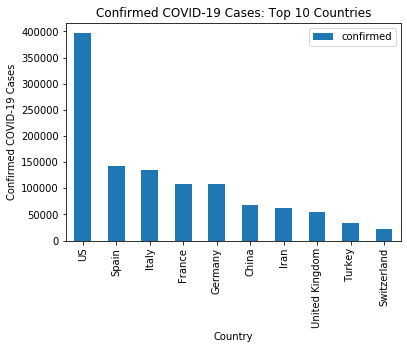

In [21]:
covid_global_mostrecent.sort_values("confirmed", ascending=False).iloc[:10].plot.bar(x="country", y="confirmed")
plt.ylabel("Confirmed COVID-19 Cases")
plt.xlabel("Country")
plt.title("Confirmed COVID-19 Cases: Top 10 Countries");

<a id='us'></a>
## U.S. COVID-19 Data
For the remainder of our EDA, we will focus on U.S. COVID-19 data. We made this decision so that we could go deeper in the analysis 

For the U.S. data, we will use the [CovidTracking Project's](https://covidtracking.com/api) dataset instead of the Johns Hopkins data set. The CovidTracking project has better access to test data. We'll start by loading and cleaning that data.

In [4]:
# load daily covid data, per state
covid_us_states = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")

In [5]:
covid_us_states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200407,AK,213.0,6700.0,NaN,NaN,23.0,NaN,NaN,NaN,...,23.0,6913,6913,6913,2,0.0,0.0,8.0,22.0,30.0
1,20200407,AL,2119.0,12797.0,NaN,NaN,271.0,NaN,NaN,NaN,...,271.0,14916,14916,14916,1,6.0,31.0,0.0,151.0,151.0
2,20200407,AR,946.0,12692.0,NaN,74.0,148.0,NaN,NaN,26.0,...,148.0,13638,13638,13638,5,0.0,11.0,722.0,71.0,793.0
3,20200407,AS,0.0,20.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,31,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200407,AZ,2575.0,30800.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33375,33375,33375,4,8.0,0.0,722.0,119.0,841.0


In [53]:
# add full state name as a column
states_dict = states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

covid_us_states["name"] = covid_us_states["state"].map(states_dict)
covid_us_states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,name
0,20200405,AK,185.0,6099.0,NaN,NaN,20.0,NaN,NaN,NaN,...,6284,6284,6284,2,1.0,4.0,230.0,14.0,244.0,Alaska
1,20200405,AL,1796.0,11282.0,NaN,NaN,231.0,NaN,NaN,NaN,...,13078,13078,13078,1,2.0,19.0,2009.0,216.0,2225.0,Alabama
2,20200405,AR,830.0,10412.0,NaN,67.0,130.0,NaN,43.0,27.0,...,11242,11242,11242,5,2.0,130.0,785.0,87.0,872.0,Arkansas
3,20200405,AS,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,26,20,20,60,0.0,0.0,0.0,0.0,0.0,American Samoa
4,20200405,AZ,2269.0,25141.0,NaN,NaN,310.0,NaN,108.0,NaN,...,27410,27410,27410,4,12.0,13.0,0.0,250.0,250.0,Arizona


In [102]:
# next, load population data
us_states_population = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv")
us_states_population = us_states_population[["NAME", "POPESTIMATE2019"]]
us_states_population.rename(columns={"NAME":"name", "POPESTIMATE2019": "population"}, inplace=True)

In [103]:
# join to cases
covid_us_states = covid_us_states.merge(us_states_population, on="name", how="inner")

# create cases/per capita and test/per capita columns
covid_us_states["positive_percap"] = covid_us_states["positive"] / covid_us_states["population"]
covid_us_states["tests_percap"] = covid_us_states["totalTestResults"] / covid_us_states["population"]
covid_us_states.head()

# join to lat/long
state_latlong = pd.read_csv("./data/statelatlong.csv")[["State", "Latitude", "Longitude"]]
state_latlong.rename(columns={"State": "state", 
                              "Latitude": "lat",
                              "Longitude": "long"}, inplace=True)
covid_us_states = covid_us_states.merge(state_latlong, on="state", how="inner")

How about a bubble plot. 
NOTE: To see the bubble plot below, please view it here:

https://nbviewer.jupyter.org/github/spottedd-spotify/disease_project/blob/master/milestone2_eda/milestone2_eda.ipynb#us

In [106]:
us_states_geo = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
date = covid_us_states["date"].max()
covid_us_states_mostrecent = covid_us_states.loc[covid_us_states["date"] == date]

In [147]:
# https://python-graph-gallery.com/313-bubble-map-with-folium/

# make an empty map of the US
m = folium.Map(location=[30, -90], zoom_start=4)
 
# add bubbles according to the relative cases
for i in range(0,len(covid_us_states_mostrecent)):
    coords = [covid_us_states_mostrecent.iloc[i]['lat'], covid_us_states_mostrecent.iloc[i]['long']]
    state = covid_us_states_mostrecent.iloc[i]['state']
    cases = int(covid_us_states_mostrecent.iloc[i]['positive'])
    cases_per_cap = covid_us_states_mostrecent.iloc[i]['positive_percap']
    
    folium.Circle(
      location=coords,
      popup=f"{state}\n{cases}",
      radius=cases_per_cap*50000000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

# plot
m


<a id='predictors'></a>
## Analyzing Predictors
As we've done with our initial EDA above, we'll only examine US COVID-19 data here. We may expand to all countries in the future. 

In the sections that follow our initial EDA, we answer the final two questions:    
* **What are the important measures?**
* **What are the right questions to ask, and how can the data answer them?**



<a id='google_community_reports'></a>
### Google COVID-19 Community Mobility Reports
In March of 2020, Google began publishing [Community Mobility Reports](https://www.google.com/covid19/mobility/), which tracked changes in activity from pre-coronavirus norms to now for countries agross the world. In particular, it tracked changes in mobility for the following six categories: 
- Retail & recreation
- Grocery & pharmacy
- Parks
- Transit stations
- Workplaces
- Residential

We'll start by loading the data. Note: Google publishes their data in pdf format. The following csv was generated by a github user's pdf scraper, and is current as of 3/29. We'll need to run the script to update the data for later iterations of this project. For time purposes, we're sticking to the 3/29 data here. 

In [140]:
# retrieve county-level mobility reports for each US state
mobility_us_states = pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/jupyter%20notebook/mobility_US_states.csv")

# condense to state-level
mobility_us_states = mobility_us_states.loc[mobility_us_states["Region"] == "Total"]

mobility_us_states.head()

,Date,State,Region,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential
0,2020-03-29,Alabama,Total,-41.0,-13.0,19.0,-30.0,-32.0,9.0
68,2020-03-29,Alaska,Total,-48.0,-27.0,18.0,-55.0,-33.0,10.0
81,2020-03-29,Arizona,Total,-40.0,-17.0,-7.0,-41.0,-33.0,10.0
97,2020-03-29,Arkansas,Total,-29.0,-7.0,81.0,-22.0,-27.0,7.0
169,2020-03-29,California,Total,-50.0,-24.0,-38.0,-54.0,-39.0,15.0


In [250]:
mobility_merged = mobility_us_states[["State", "Retail & recreation", "Grocery & pharmacy",
                                      "Parks", "Transit stations", "Workplaces", "Residential"]]
mobility_merged = mobility_merged.merge(covid_us_states.loc[covid_us_states["date"] == 20200329],
                                        how="inner", left_on="State", right_on="name")[
    ["state", "name", "Retail & recreation", "Grocery & pharmacy", "Parks", "Transit stations",
     "Workplaces", "Residential", "positive_percap"]]

mobility_merged.head()
# covid_us_states.loc[covid_us_states["date"] == 20200329]

,state,name,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential,positive_percap
0,AL,Alabama,-41.0,-13.0,19.0,-30.0,-32.0,9.0,0.000164
1,AK,Alaska,-48.0,-27.0,18.0,-55.0,-33.0,10.0,0.000139
2,AZ,Arizona,-40.0,-17.0,-7.0,-41.0,-33.0,10.0,0.000126
3,AR,Arkansas,-29.0,-7.0,81.0,-22.0,-27.0,7.0,0.000141
4,CA,California,-50.0,-24.0,-38.0,-54.0,-39.0,15.0,0.000144


Now, let's examine whether changes in mobility are associated with changes in cases per capita in each state. First, let's examine mobility for Retail & recreation across all states.

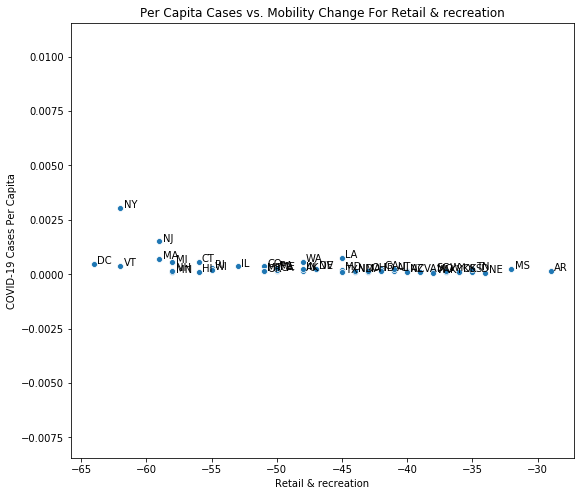

In [203]:
# set figsize and plot scatter
fig, ax = plt.subplots(figsize=(9,8))
mobility_cat = "Retail & recreation"
ax = sns.scatterplot(x=mobility_cat, y="positive_percap", data=mobility_merged)

# add annotations one by one with a loop
# https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
for row in range(0, mobility_merged.shape[0]):
     ax.text(mobility_merged[mobility_cat].iloc[row]+0.25, 
            mobility_merged["positive_percap"].iloc[row], 
            mobility_merged["state"].iloc[row], 
            horizontalalignment='left', size='medium', color='black')

# ax.set_ylim((0, 0.001))
ax.set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cat}")
ax.set_ylabel("COVID-19 Cases Per Capita");


As can see, this chart is not super helpful because of our two huge outliers, NY and NJ. Zooming in a bit, we get a better feel for the relationship between the change in visits to Retail/recreation venues and cases per capita. I've left NY and NJ in this plot purposefully so you can see how far they are from the other points. They are huge outliers, which is unsurprising. For the remainder of our mobility analysis, we'll exclude those two states.

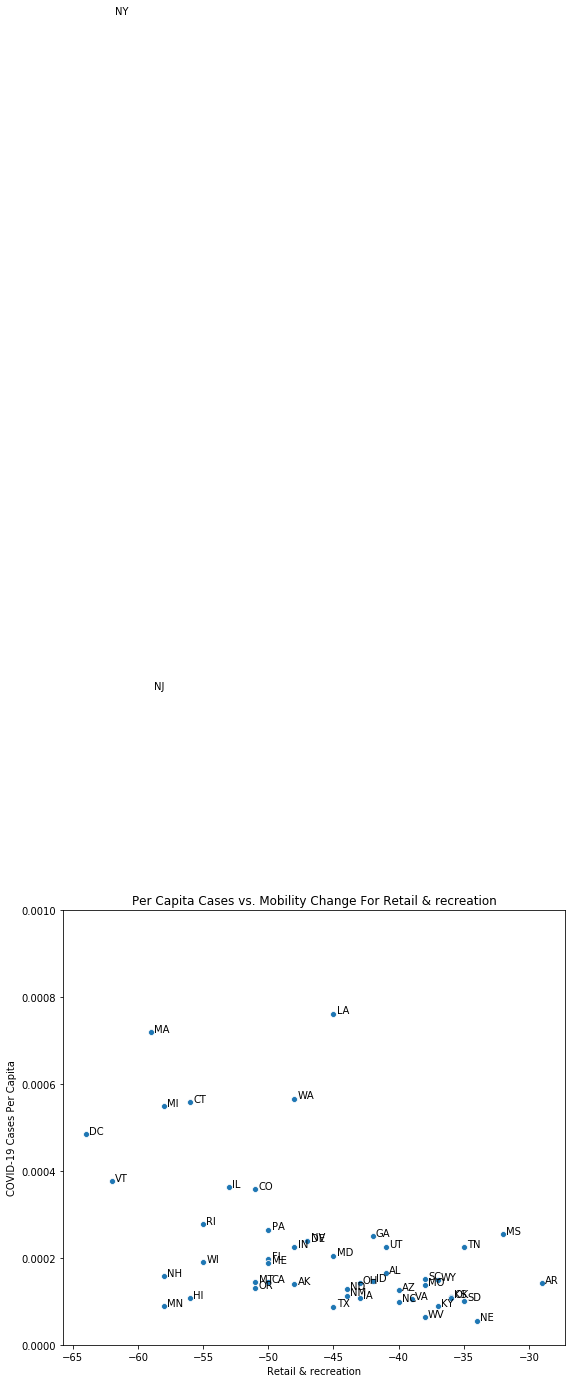

In [204]:
# set figsize and plot scatter
fig, ax = plt.subplots(figsize=(9,8))
mobility_cat = "Retail & recreation"
ax = sns.scatterplot(x=mobility_cat, y="positive_percap", data=mobility_merged)

# add annotations one by one with a loop
# https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
for row in range(0, mobility_merged.shape[0]):
     ax.text(mobility_merged[mobility_cat].iloc[row]+0.25, 
            mobility_merged["positive_percap"].iloc[row], 
            mobility_merged["state"].iloc[row], 
            horizontalalignment='left', size='medium', color='black')

ax.set_ylim((0, 0.001))
ax.set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cat}")
ax.set_ylabel("COVID-19 Cases Per Capita");


In [206]:
# remove NY and NJ
mobility_nooutliers = mobility_merged.loc[~mobility_merged["state"].isin(["NY", "NJ"])]

Now that we have removed outliers, let's examine the relationship beteween mobility and cases per capita for all mobility categories

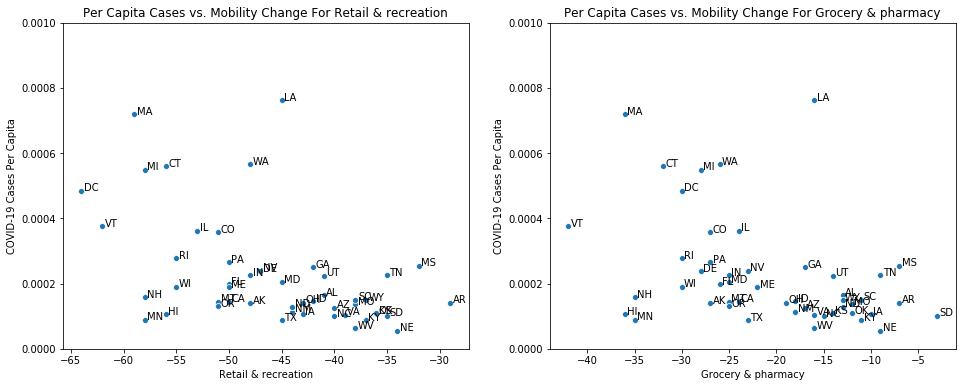

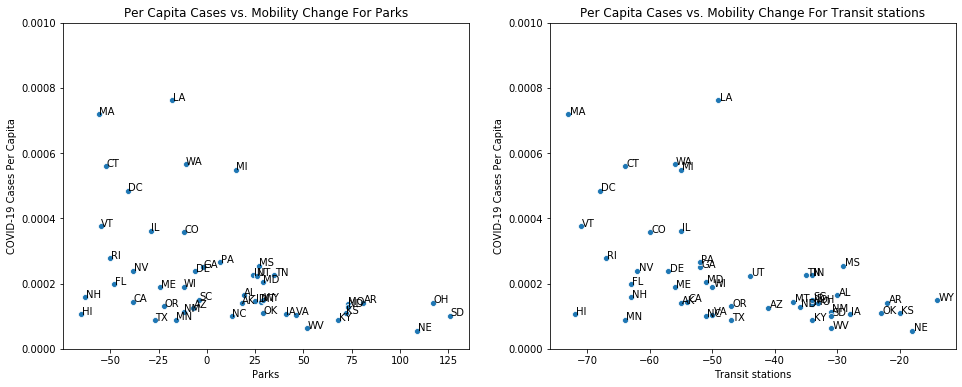

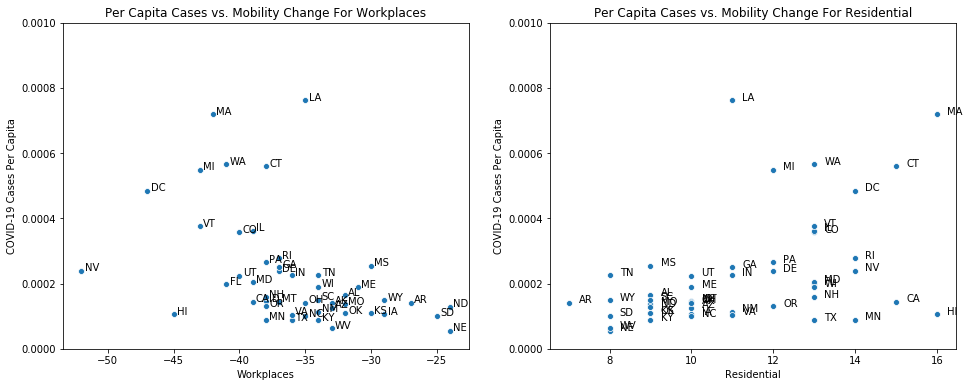

In [232]:
# set figsize and axes and plot scatter
fig, ax = plt.subplots(1, 2, figsize=(16,6))
mobility_cats = ["Retail & recreation", "Grocery & pharmacy", "Parks", "Transit stations",
                 "Workplaces", "Residential"]

for i in range (0, 2):
    i_ax = i-0
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim((0, 0.001))
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");

fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range (2, 4):
    i_ax = i-2
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim((0, 0.001))
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");


fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range (4, 6):
    i_ax = i-4
    ax[i_ax] = sns.scatterplot(x=mobility_cats[i], y="positive_percap", data=mobility_nooutliers, ax=ax[i_ax])

    # add annotations one by one with a loop
    # https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/
    for row in range(0, mobility_nooutliers.shape[0]):
        ax[i_ax].text(mobility_nooutliers[mobility_cats[i]].iloc[row]+0.25, 
                mobility_nooutliers["positive_percap"].iloc[row], 
                mobility_nooutliers["state"].iloc[row], 
                horizontalalignment='left', size='medium', color='black')

        ax[i_ax].set_ylim((0, 0.001))
        ax[i_ax].set_title(f"Per Capita Cases vs. Mobility Change For {mobility_cats[i]}")
        ax[i_ax].set_ylabel("COVID-19 Cases Per Capita");

In [249]:
correlations = []
correlations_nooutliers = []

for cat in mobility_cats:
    correlations.append({"mobility_category": cat,
                         "correlation": np.correlate(
                             mobility_merged[cat], 
                             mobility_merged["positive_percap"])[0]})
    correlations_nooutliers.append({"mobility_category": cat,
                         "correlation (outliers removed)": np.correlate(
                             mobility_nooutliers[cat], 
                             mobility_nooutliers["positive_percap"])[0]})

display(pd.DataFrame(correlations))
display(pd.DataFrame(correlations_nooutliers))

,mobility_category,correlation
0,Retail & recreation,-0.812776
1,Grocery & pharmacy,-0.404950
2,Parks,-0.259097
3,Transit stations,-0.875892
4,Workplaces,-0.619349
5,Residential,0.203963


,mobility_category,correlation (outliers removed)
0,Retail & recreation,-0.534187
1,Grocery & pharmacy,-0.257321
2,Parks,-0.061059
3,Transit stations,-0.562370
4,Workplaces,-0.412314
5,Residential,0.130902


<a id='google_search_data'></a>
### Google search data
To conduct this analysis, we'll use [pytrends](https://github.com/GeneralMills/pytrends) a libary that allows you to query the GoogleTrends API for search data

In [2]:
import pytrends
from pytrends.request import TrendReq
from googletrans import Translator

# connect 
pyt = TrendReq(hl='en-US', tz=300)

Now, we can start examining searhes. Let us first examine searches for "coronavirus"

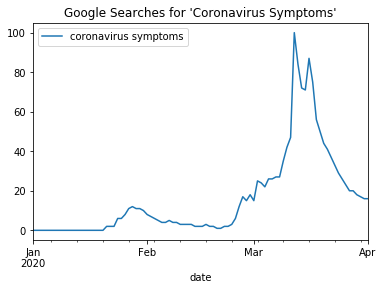

In [448]:
# build query: coronavirus searches starting at 2020
kw_list = ["coronavirus symptoms"]
pyt.build_payload(kw_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='US', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y="coronavirus symptoms")
plt.title("Google Searches for 'Coronavirus Symptoms'");


Another cool feature of the pytrends library is that you can fetch suggested queries related to your own. Let's fetch keywords similar to `coronavirus`. Keep in mind that these are the top queries similar queries over the time period: `2020-01-01` to `2020-04-01` within the United States.

In [432]:
pyt.related_queries()["coronavirus symptoms"]["top"]

,query,value
0,symptoms of coronavirus,100
1,the coronavirus symptoms,35
2,the symptoms of coronavirus,23
3,the symptoms of the coronavirus,23
4,corona symptoms,17
5,corona,16
6,symptoms for coronavirus,16
7,what are coronavirus symptoms,14
8,flu symptoms,11
9,what are symptoms of coronavirus,11


Let's plot the first few of these over time

In [449]:
# fetch top 5 related queries
related_5 = pyt.related_queries()["coronavirus symptoms"]["top"].iloc[:5]["query"].values

# build new query: related coronavirus queries
kw5_list = related_5
pyt.build_payload(kw5_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='US', gprop='')
top5 = pyt.interest_over_time()
top5 = top5.reset_index()
top5["date"] = pd.to_datetime(top5["date"], infer_datetime_format=True) 

In [434]:
top5.tail()

,date,symptoms of coronavirus,the coronavirus symptoms,the symptoms of coronavirus,the symptoms of the coronavirus,corona symptoms,isPartial
87,2020-03-28,19,8,5,5,29,False
88,2020-03-29,18,7,5,5,27,False
89,2020-03-30,18,7,5,5,26,False
90,2020-03-31,18,7,5,5,25,False
91,2020-04-01,17,7,5,5,24,False


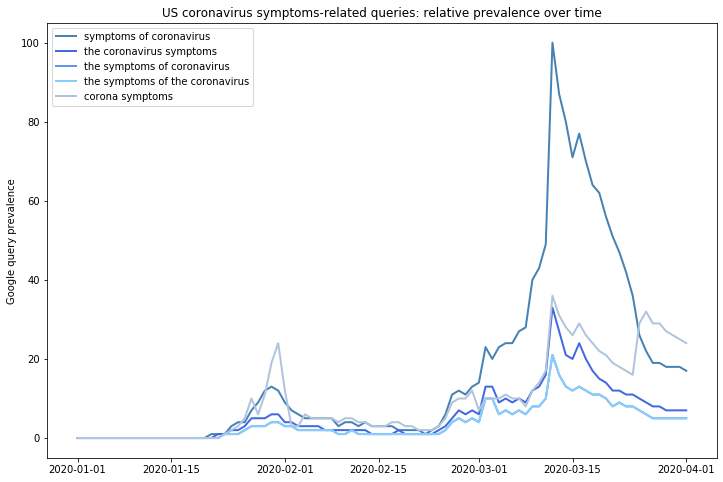

In [437]:
# now plot top 5 related queries
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot("date", kw5_list[0], data=top5, color='steelblue', linewidth=2)
plt.plot("date", kw5_list[1], data=top5, color='royalblue', linewidth=2)
plt.plot("date", kw5_list[2], data=top5, color='cornflowerblue', linewidth=2) 
plt.plot("date", kw5_list[3], data=top5, color='lightskyblue', linewidth=2)
plt.plot("date", kw5_list[4], data=top5, color='lightsteelblue', linewidth=2)
plt.legend(loc="upper left")
plt.ylabel("Google query prevalence")
plt.title("US coronavirus symptoms-related queries: relative prevalence over time");


Interesting - now let's overlay a plot of US coronavirus cases

In [486]:
# fetch US data and clean date
covid_us = covid_global.loc[covid_global["country"] == "US"]
covid_us["date"] =  pd.to_datetime(covid_us["date"], infer_datetime_format=True)  

# merge search
search_cases_us = top5.merge(covid_us, left_on="date", right_on="date", how="inner")#[[
#    "date", "coronavirus update", "coronavirus symptoms", "coronavirus cases", 
 #   "coronavirus us", "coronavirus map", "confirmed"]]
search_cases_us["new_confirmed"] = search_cases_us["confirmed"].diff()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


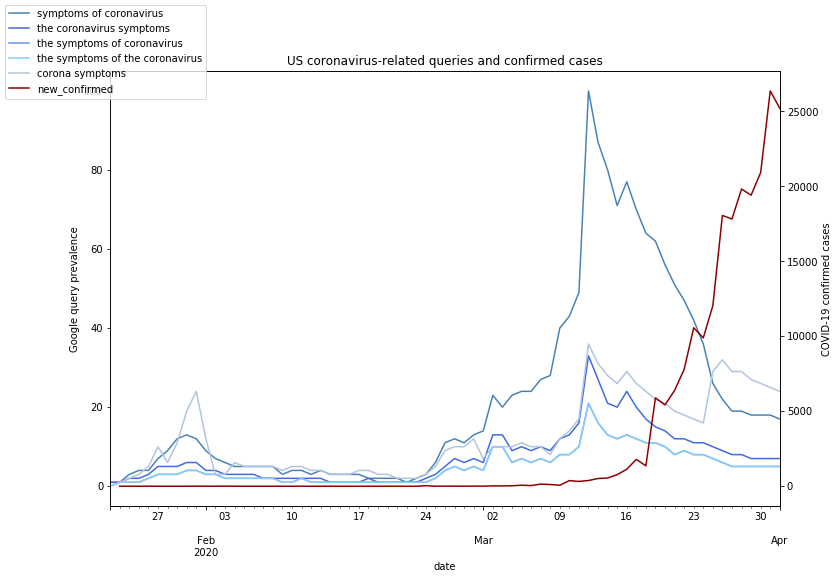

In [496]:
# now plot top 5 related queries with confirmed cases
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
search_cases_us.plot(x="date", y=kw5_list[0], color="steelblue",  ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[1], color="royalblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[2], color="cornflowerblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[3], color="lightskyblue", ax=ax1, legend=False)
search_cases_us.plot(x="date", y=kw5_list[4], color="lightsteelblue", ax=ax1, legend=False)
ax2 = ax1.twinx()
# search_cases_us.plot(x="date", y="confirmed", ax=ax2, legend=False, color="r")
search_cases_us.plot(x="date", y="new_confirmed", ax=ax2, legend=False, color="darkred")

ax1.figure.legend(loc="upper left")
ax1.set_title("US coronavirus-related queries and confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 confirmed cases")
plt.show();

**Analysis**

Interestingly, in the US at least, it appears that there was a spike in coronavirus symptoms-related searches about two weeks before the massive spike in confirmed cases. At first glance, it appears this could be a good predictor of actual coronavirus cases. If that is the case, then the drop in "symptoms" searches might be predictive of a leveling off of confirmed cases.

Let's look at a different country that is further along in its curve: South Korea


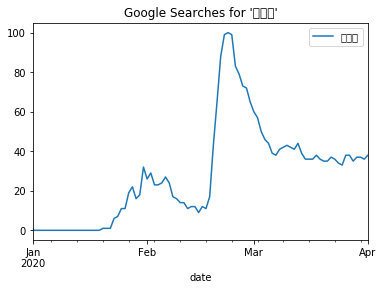

In [508]:
# build query: coronavirus searches starting at 2020, for south korea
kw_list = ["코로나"]
pyt.build_payload(kw_list, cat=0, timeframe='2020-01-01 2020-04-01', geo='KR', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y=kw_list[0])
plt.title(f"Google Searches for '{kw_list[0]}'");


In [510]:
pyt.related_queries()[kw_list[0]]["top"]

,query,value
0,코로나 확진,100
1,코로나 확진 자,94
2,코로나 바이러스,75
3,코로나 19,58
4,코로나 현황,38
5,코로나 증상,30
6,신종 코로나,28
7,세계 코로나,15
8,실시간 코로나,13
9,신종 코로나 바이러스,13


In [5]:
translator = Translator()
translator.translate('코로나 확진', dest="en")

In [481]:
# fetch south korea data and clean date
covid_sk = covid_global.loc[covid_global["country"] == "Korea, South"]
covid_sk["date"] =  pd.to_datetime(covid_sk["date"], infer_datetime_format=True)  

# merge search
search_cases_sk = search_coronavirus.merge(covid_sk, left_on="date", right_on="date", how="inner")
search_cases_sk["new_confirmed"] = search_cases_sk["confirmed"].diff()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


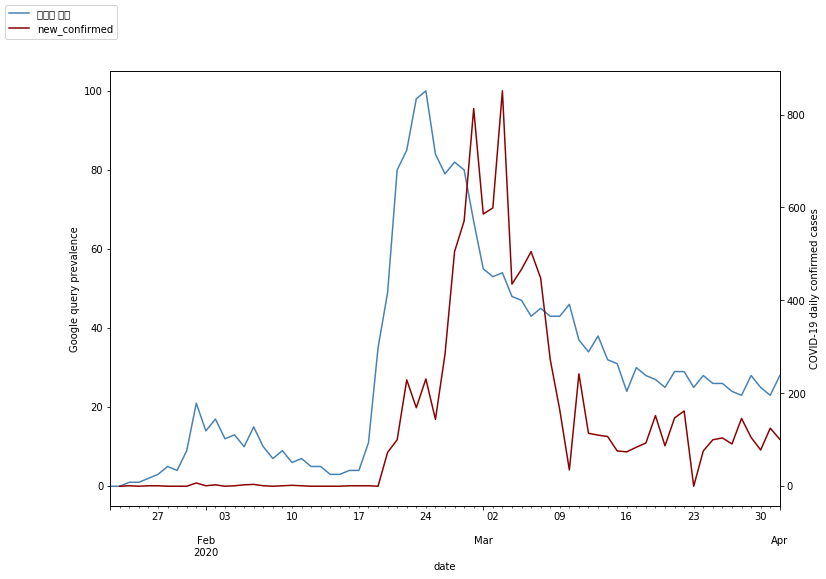

In [495]:
# now plot top 5 related queries with confirmed cases
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
search_cases_sk.plot(x="date", y=kw_list[0], color="steelblue",  ax=ax1, legend=False)
ax2 = ax1.twinx()
search_cases_sk.plot(x="date", y="new_confirmed", color="darkred",  ax=ax2, legend=False)
# search_cases_sk.plot(x="date", y="confirmed", ax=ax2, legend=False, color="r")

ax1.figure.legend(loc="upper left")
# ax1.set_title("coronavirus-related queries and confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 daily confirmed cases")
plt.show();

## Future ideas

#### Additional data
- Whether state went on lockdown
- COVID-19 Community Mobility Reports from [Google](https://www.google.com/covid19/mobility/)

#### Data engineering:
- How many days since lockdown